In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [20]:
df = pd.read_csv("data/df_new_feats.csv")

df_x = df[['Aroma', 'Flavor', 'Aftertaste', 'Acidity', 'Body', 'Balance', 'Overall']]
df_y = df[['continent']]

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, stratify=df_y, random_state=42)


In [21]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, StratifiedKFold
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import f1_score
import numpy as np
#from tqdm import tqdm

def make_model(ml_model, model_name):
    scaler = StandardScaler()
    sm = SMOTE(random_state=42,k_neighbors=5)
    pipe = imbpipeline(steps=[("smote", sm), ("scaler", scaler), (model_name, ml_model)])
    return pipe

class ModelEvaluator:

    def __init__(self, model_name, model, param_grid, pipeline_maker = make_model ):
        self.name = model_name
        self.estimator = pipeline_maker(model, model_name)
        self.best_params = []
        self.outer_cv_score = []
        self.param_grid = param_grid

    def push_best_params(self, entry):
        self.best_params.append(entry)

    def push_inner_cv_score(self, entry):
        self.best_params.append(entry)
    
    def push_outer_cv_score(self, entry):
        self.outer_cv_score.append(entry)

    def get_outer_cv_score_results(self):
        ocvs = np.array(self.outer_cv_score)
        return ocvs.mean(), ocvs.std()

def make_classification_model_list():

    model_list = [None] * 6

    model_list[0] = ModelEvaluator(
        model_name = "knn",
        model = KNeighborsClassifier(),
        param_grid = {
            "knn__n_neighbors": [3,5,7,9],
            "knn__p": [1, 1.5, 2],       
        }
    )

    model_list[1] = ModelEvaluator(
        model_name = "svc",
        model = SVC(),
        param_grid = {
            "svc__C": [0.01,0.1,0.5,1,5,10,50,100],
            "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],       
        }
    )

    model_list[2] = ModelEvaluator(
        model_name = "gnb",
        model = GaussianNB(),
        param_grid = {}
    )

    model_list[3] = ModelEvaluator(
        model_name = "dt",
        model = DecisionTreeClassifier(random_state=42),
        param_grid = {
            "dt__criterion": ["gini", "entropy"],
            "dt__ccp_alpha": [0,0.005,0.01,0.015,0.02,0.03]
        }
    )

    model_list[4] = ModelEvaluator(
        model_name = "rf",
        model = RandomForestClassifier(random_state=42),
        param_grid = {}
    )

    model_list[5] = ModelEvaluator(
        model_name = "ada",
        model = AdaBoostClassifier(random_state=42),
        param_grid = {}
    )
    return model_list

continent_model_list = make_classification_model_list()


In [22]:
def f1_macro_scorer(model, X, y):
    return f1_score(model.predict(X),y, average="macro")


def nested_cross_valitation(outer_folds, inner_folds, model_list, scorer, X_train, y_train, n_trials=1):

    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    NUM_TRIALS = n_trials
    for i in range(NUM_TRIALS):
        inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
        for train, test in outer_cv.split(X_train, y_train):
            for model in model_list:
                clf = GridSearchCV(estimator=model.estimator, param_grid=model.param_grid, cv=inner_cv)
                clf.fit(X_train.iloc[train], y_train[train])
                outer_cv_score = scorer(clf, X=X_train.iloc[test], y=y_train[test])
                model.push_best_params(clf.best_params_)
                model.push_outer_cv_score(outer_cv_score)

nested_cross_valitation(
    model_list = continent_model_list,
    outer_folds = 5,
    inner_folds = 5,
    scorer = f1_macro_scorer,
    X_train = X_train,
    y_train = y_train["continent"].ravel() #warning chato
)


In [23]:
for model in continent_model_list:
    mean, std = model.get_outer_cv_score_results()
    print(f"{model.name} mean: {mean:1.2f} ({std:1.2f})")

knn mean: 0.48 (0.12)
svc mean: 0.45 (0.09)
gnb mean: 0.35 (0.07)
dt mean: 0.48 (0.13)
rf mean: 0.49 (0.09)
ada mean: 0.30 (0.07)


In [24]:
continent_model_list[3].best_params

[{'dt__ccp_alpha': 0.015, 'dt__criterion': 'entropy'},
 {'dt__ccp_alpha': 0.015, 'dt__criterion': 'gini'},
 {'dt__ccp_alpha': 0.02, 'dt__criterion': 'entropy'},
 {'dt__ccp_alpha': 0, 'dt__criterion': 'gini'},
 {'dt__ccp_alpha': 0.03, 'dt__criterion': 'gini'}]

In [25]:
from sklearn.metrics import classification_report


best_model = make_model(RandomForestClassifier(random_state=42),"rf")
best_model.fit(X_train, y_train)
print(classification_report(y_test, best_model.predict(X_test)))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


              precision    recall  f1-score   support

      Africa       0.40      0.29      0.33         7
     America       0.56      0.47      0.51        30
        Asia       0.44      0.56      0.49        25

    accuracy                           0.48        62
   macro avg       0.47      0.44      0.44        62
weighted avg       0.49      0.48      0.48        62



In [26]:
report = classification_report(y_test, best_model.predict(X_test), output_dict=True)

In [27]:
ans = []
conts = ["America", "Asia", "Africa"]
for cont in conts:
    dico = report[cont]
    ans.append(pd.DataFrame({
        "Continent": [cont] * 2,
        "metric": ["precision", "recall"],
        "value": [dico["precision"], dico["recall"]] }))

report_df = pd.concat(ans)

In [28]:
report_df

,Continent,metric,value
0,America,precision,0.560000
1,America,recall,0.466667
0,Asia,precision,0.437500
1,Asia,recall,0.560000
0,Africa,precision,0.400000
1,Africa,recall,0.285714


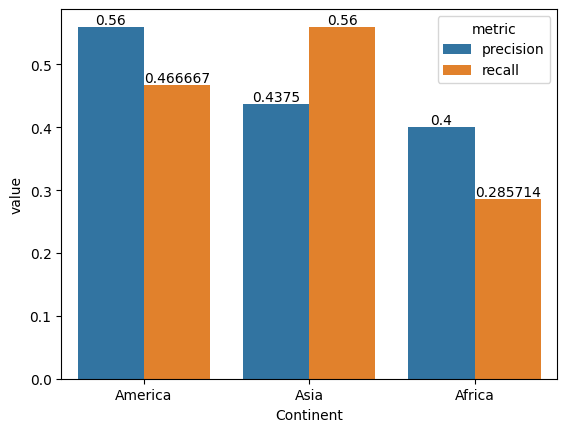

In [29]:
ax = sns.barplot(data=report_df, x="Continent", y="value", hue="metric")

for i in ax.containers:
    ax.bar_label(i,)

Interpretabilidade PDP

In [13]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from interpret import show
from interpret.blackbox import PartialDependence

seed = 42
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

pca = PCA()
rf = RandomForestClassifier(random_state=seed)

blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
blackbox_model.fit(X_train, y_train)

pdp = PartialDependence(blackbox_model, X_train)

show(pdp.explain_global(), 0)

Interpretabilidade Shap

In [31]:
import shap
shap.initjs()

In [35]:
from sklearn.metrics import classification_report


best_model = RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)
best_model.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [36]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)

In [43]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

In [45]:
shap.force_plot(explainer.expected_value[1], shap_values[1][1,:], X_train.iloc[1,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


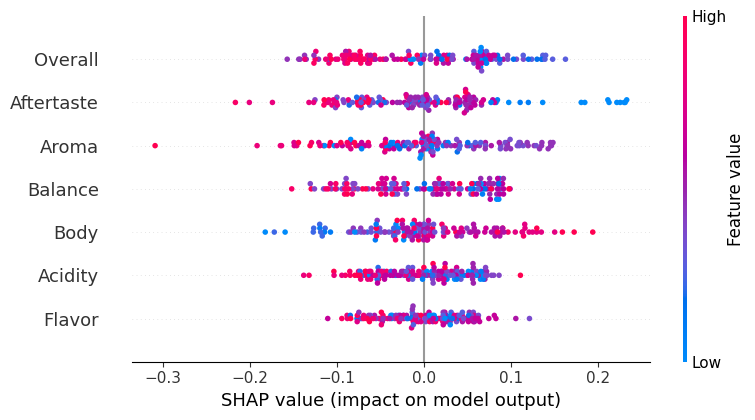

In [41]:
shap.summary_plot(shap_values[1], X_train)